<a href="https://colab.research.google.com/github/nevil120/Pytorch/blob/main/02_binary_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Binary Classification

In [ ]:
# Import torch
import torch

# Setup device agnostic code
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

print(device)

# Setup random seed
RANDOM_SEED = 42

cuda


## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [ ]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=1000, random_state=42, noise=0.3)

In [ ]:
# Turn data into a DataFrame
import pandas as pd

moons_df = pd.DataFrame({'X1:': X[:,0], 'X2:': X[:,1], 'y:': y})
moons_df

,X1:,X2:,y:
0,-0.171863,0.596249,1
1,1.253283,-0.265414,1
2,0.723224,0.231943,1
3,-0.065198,-0.655194,1
4,-0.799493,0.552935,0
...,...,...,...
995,0.861014,0.343843,0
996,-0.229425,0.754849,0
997,1.770957,-0.509436,1
998,-1.061772,0.006786,0


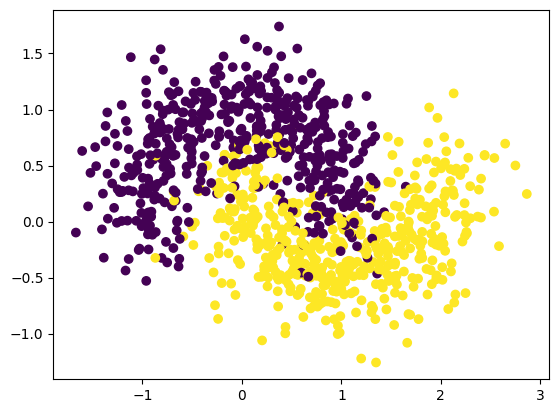

In [ ]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y)

In [ ]:
# Turn data into tensors of dtype float
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [ ]:
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, in_features, hidden_layer_nodes, out_features):
      super().__init__()
      self.layer_1 = nn.Linear(in_features, hidden_layer_nodes)
      self.layer_2 = nn.Linear(hidden_layer_nodes, hidden_layer_nodes)
      self.layer_3 = nn.Linear(hidden_layer_nodes, out_features)
      self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        return x

# Instantiate the model
moon_model = MoonModelV0(2, 5, 1).to(device)
moon_model

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=5, bias=True)
  (layer_3): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [ ]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(moon_model.parameters(), lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [ ]:
# What's coming out of our model?
samples = X_test_tensor[:5]

# logits (raw outputs of model)
logits = moon_model(samples.to(device))
print("Logits:", logits)

# Prediction probabilities
pred_probs = torch.sigmoid(logits)
print("Pred probs:", pred_probs)

# Prediction labels
labels = torch.round(pred_probs)
print("Pred labels:", labels)

Logits: tensor([[-0.2965],
        [-0.3470],
        [-0.3431],
        [-0.3419],
        [-0.3365]], device='cuda:0', grad_fn=<AddmmBackward0>)
Pred probs: tensor([[0.4264],
        [0.4141],
        [0.4151],
        [0.4154],
        [0.4167]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)


In [ ]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.5 MB/s eta 0:00:00


MulticlassAccuracy()

In [ ]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 2000

# Send data to the device
X_train = X_train_tensor.to(device)
X_test = X_test_tensor.to(device)
y_train = y_train_tensor.unsqueeze(dim=1).to(device)
y_test = y_test_tensor.unsqueeze(dim=1).to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  moon_model.train()

  # 1. Forward pass (logits output)
  y_logits = moon_model(X_train)

  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  moon_model.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    y_test_logits = moon_model(X_test)

    # Turn the test logits into prediction labels
    y_test_pred_probs = torch.sigmoid(y_test_logits)

    # 2. Caculate the test loss/acc
    y_test_pred = torch.round(y_test_pred_probs)

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = acc_fn(y_test_pred, y_test.int())

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch - {epoch}, train_loss - {loss}, train_acc - {acc}, test_loss - {test_loss}, test_acc - {test_acc}")

Epoch - 0, train_loss - 0.7185387015342712, train_acc - 0.5, test_loss - 0.7140231132507324, test_acc - 0.5
Epoch - 100, train_loss - 0.5391174554824829, train_acc - 0.8212500214576721, test_loss - 0.5502252578735352, test_acc - 0.8050000071525574
Epoch - 200, train_loss - 0.38997942209243774, train_acc - 0.8537499904632568, test_loss - 0.40738752484321594, test_acc - 0.8050000071525574
Epoch - 300, train_loss - 0.35403865575790405, train_acc - 0.8587499856948853, test_loss - 0.3680514097213745, test_acc - 0.8199999928474426
Epoch - 400, train_loss - 0.3376712203025818, train_acc - 0.8612499833106995, test_loss - 0.34844037890434265, test_acc - 0.824999988079071
Epoch - 500, train_loss - 0.32945868372917175, train_acc - 0.8612499833106995, test_loss - 0.3400096893310547, test_acc - 0.824999988079071
Epoch - 600, train_loss - 0.326048880815506, train_acc - 0.8637499809265137, test_loss - 0.3357742130756378, test_acc - 0.8299999833106995
Epoch - 700, train_loss - 0.32345062494277954, tra

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [ ]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

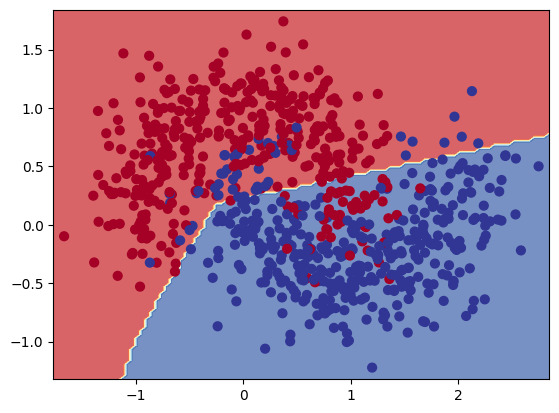

In [ ]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(moon_model, X_train, y_train)

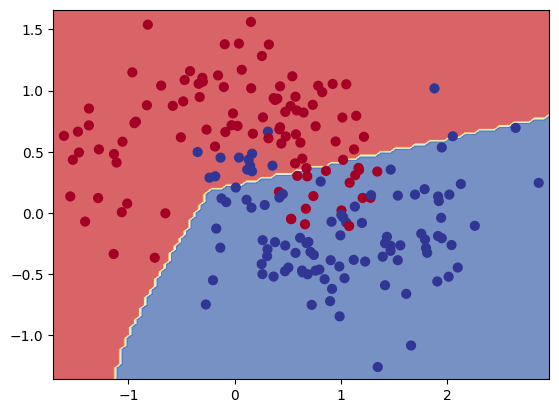

In [ ]:
plot_decision_boundary(moon_model, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

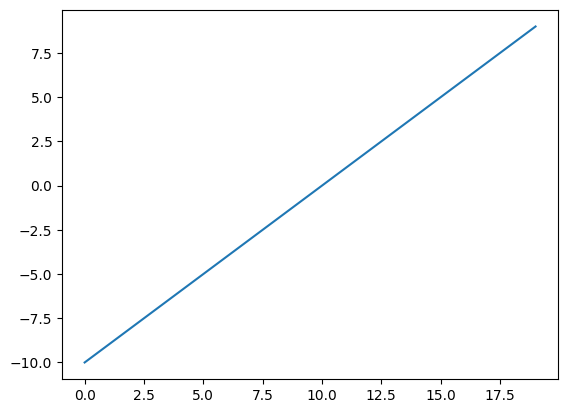

In [ ]:
# Create a straight line tensor
A = torch.arange(-10, 10, 1)
plt.plot(A)

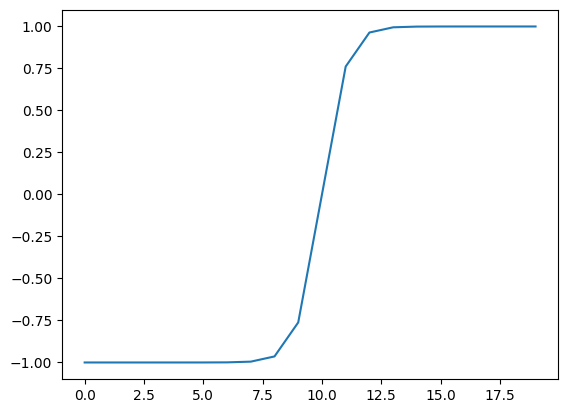

In [ ]:
# Test torch.tanh() on the tensor and plot it
plt.plot(torch.tanh(A))

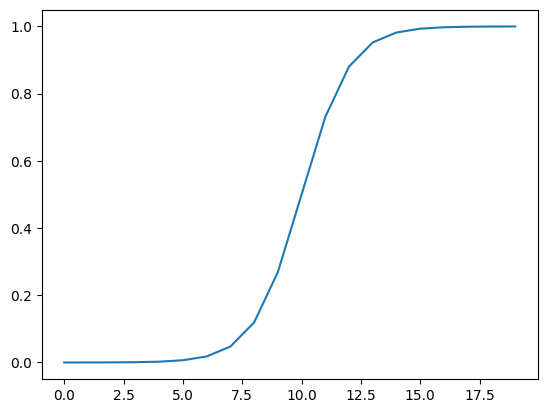

In [ ]:
# Replicate torch.tanh() and plot it
def sigmoid_function(x):
  return 1 / (1 + torch.exp(-x))

plt.plot(sigmoid_function(A))